In [1]:
# Definir la ruta de las carpetas
ruta_DE2_train = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/dataset_etapa2/train"
ruta_DE2_val = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/dataset_etapa2/val"
ruta_DE2_test = "/Users/claracelestechavezcotrina/Downloads/DATA_TESIS/dataset_etapa2/test"

In [6]:
# Importar el Generador de datos
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [8]:
# Creamos el generador para las carpetas "train", "val" y "test"
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [9]:
# Cargar datos en Keras
IMG_SIZE = (224, 224)
BATCH_SIZE = 8

train_gen = train_datagen.flow_from_directory(
    ruta_DE2_train,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    ruta_DE2_val,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    ruta_DE2_test,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print(train_gen.class_indices)

Found 232 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
{'birads_3': 0, 'birads_4': 1, 'birads_5': 2}


In [10]:
# Calcular Class Weights
# birads_3: 0
# birads_4: 1
# birads_5: 2

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = train_gen.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.3925549915397631, 1: 2.8641975308641974, 2: 9.666666666666666}


In [11]:
# Modelo con DenseNet121 (Transfer Learning)
# Construyendo el modelo usando la CNN preentrenada DenseNet121
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

2026-01-02 12:31:21.783353: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-02 12:31:21.783566: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-01-02 12:31:21.784563: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-01-02 12:31:21.785087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-02 12:31:21.785469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# Clasificador
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation="softmax")(x) # 3: es el número de clases

model = Model(inputs=base_model.input, outputs=outputs)

In [13]:
# Compilación (enfoque clínico)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc", multi_label=True),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [14]:
# Entrenamiento
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=4,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "densenet121_etapa2_birads3_4_5.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

In [16]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4009 - auc: 0.3705 - loss: 2.8018 - precision: 0.4038 - recall: 0.3707 - val_accuracy: 0.2400 - val_auc: 0.3264 - val_loss: 1.2338 - val_precision: 0.1667 - val_recall: 0.1200 - learning_rate: 3.0000e-05
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 948ms/step - accuracy: 0.4009 - auc: 0.4985 - loss: 2.1257 - precision: 0.4000 - recall: 0.3621 - val_accuracy: 0.1400 - val_auc: 0.3316 - val_loss: 1.4331 - val_precision: 0.0645 - val_recall: 0.0400 - learning_rate: 3.0000e-05
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 936ms/step - accuracy: 0.3276 - auc: 0.4755 - loss: 1.9978 - precision: 0.3287 - recall: 0.3060 - val_accuracy: 0.1000 - val_auc: 0.3314 - val_loss: 1.5396 - val_precision: 0.0312 - val_recall: 0.0200 - learning_rate: 3.0000e-05
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 943ms/step - accuracy: 0.2931 - auc: 0.4902 - loss: 1.9411 - precision: 0.3058 - recall: 0.2716 - val_accuracy: 0.1000 - val_auc: 0.3341 - val_loss:

In [17]:
# Nunca se hace fine-tuning sin haber entrenado antes el head congelado
# Fine - tunning
# Descongelamos solo las últimas 30
for layer in base_model.layers[-30:]:
    layer.trainable = True

# verificando
for layer in base_model.layers[-35:]:
    print(layer.name, layer.trainable)

conv5_block12_1_conv False
conv5_block12_1_bn False
conv5_block12_1_relu False
conv5_block12_2_conv False
conv5_block12_concat False
conv5_block13_0_bn True
conv5_block13_0_relu True
conv5_block13_1_conv True
conv5_block13_1_bn True
conv5_block13_1_relu True
conv5_block13_2_conv True
conv5_block13_concat True
conv5_block14_0_bn True
conv5_block14_0_relu True
conv5_block14_1_conv True
conv5_block14_1_bn True
conv5_block14_1_relu True
conv5_block14_2_conv True
conv5_block14_concat True
conv5_block15_0_bn True
conv5_block15_0_relu True
conv5_block15_1_conv True
conv5_block15_1_bn True
conv5_block15_1_relu True
conv5_block15_2_conv True
conv5_block15_concat True
conv5_block16_0_bn True
conv5_block16_0_relu True
conv5_block16_1_conv True
conv5_block16_1_bn True
conv5_block16_1_relu True
conv5_block16_2_conv True
conv5_block16_concat True
bn True
relu True


In [18]:
# Re-compilación OBLIGATORIA
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=2.0),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc", multi_label=True),
        tf.keras.metrics.Recall(name="recall")
    ]
)

In [19]:
# Actualizamos callbacks
callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "densenet121_etapa2_finetuned.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

In [20]:
# Entrenamiento con fine-tuning
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks_ft
)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6853 - auc: 0.4665 - loss: 0.4718 - recall: 0.6466 - val_accuracy: 0.2600 - val_auc: 0.3189 - val_loss: 0.1428 - val_recall: 0.1400 - learning_rate: 1.0000e-05
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 984ms/step - accuracy: 0.5819 - auc: 0.3932 - loss: 0.5108 - recall: 0.5345 - val_accuracy: 0.2400 - val_auc: 0.3267 - val_loss: 0.1530 - val_recall: 0.1200 - learning_rate: 1.0000e-05
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 975ms/step - accuracy: 0.5388 - auc: 0.5297 - loss: 0.3222 - recall: 0.4828 - val_accuracy: 0.2000 - val_auc: 0.3444 - val_loss: 0.1600 - val_recall: 0.0800 - learning_rate: 1.0000e-05
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 977ms/step - accuracy: 0.5086 - auc: 0.5059 - loss: 0.3539 - recall: 0.4784 - val_accuracy: 0.2200 - val_auc: 0.3550 - val_loss: 0.1528 - val_recall: 0.1400 - learning_rate: 1.0000e-05
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 952ms/step - accuracy: 0.5603 - auc: 0.5909 - loss: 0

In [12]:
# Evaluación con la carpeta test
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(test_gen)
y_pred = (preds > 0.5).astype(int)

print(classification_report(test_gen.classes, y_pred))
print(confusion_matrix(test_gen.classes, y_pred))

28/28 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
              precision    recall  f1-score   support

           0       0.96      0.61      0.74       388
           1       0.21      0.80      0.33        50

    accuracy                           0.63       438
   macro avg       0.58      0.70      0.54       438
weighted avg       0.87      0.63      0.70       438

[[236 152]
 [ 10  40]]


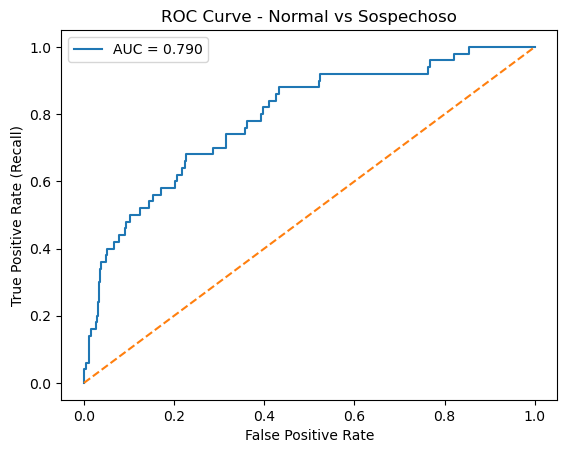

In [14]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = test_gen.classes
y_scores = preds.ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Normal vs Sospechoso")
plt.legend()
plt.show()

In [16]:
# Encontrar un umbral con mayor sensibilidad
import numpy as np

for t in [0.3, 0.25, 0.2]:
    y_pred_t = (y_scores >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_true, y_pred_t))


Threshold = 0.3
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       388
           1       0.12      1.00      0.21        50

    accuracy                           0.15       438
   macro avg       0.56      0.52      0.15       438
weighted avg       0.90      0.15      0.10       438


Threshold = 0.25
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       388
           1       0.11      1.00      0.21        50

    accuracy                           0.12       438
   macro avg       0.56      0.50      0.11       438
weighted avg       0.90      0.12      0.03       438


Threshold = 0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       388
           1       0.11      1.00      0.20        50

    accuracy                           0.11       438
   macro avg       0.06      0.50      0.10       438
weighted avg       0.0

/opt/miniconda3/envs/mamografia/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/mamografia/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/mamografia/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [17]:
# Guardar modelo
model.save("densenet121_etapa1_birads1-2_vs_3-5.keras")

In [18]:
# Guardar métricas finales
import json

metrics_etapa1 = {
    "auc_test": 0.79,
    "recall_sospechoso": 0.80,
    "threshold": 0.5
}

with open("Modelos/Etapa1/metrics.json", "w") as f:
    json.dump(metrics_etapa1, f, indent=4)
